In [30]:
import pandas as pd
from pathlib import Path
"counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_kt=0.33_re=False_gemma-2-9b"
"counterfactual_results/nf=300_fl=32_nt=10_nt=30_ne=5_kt=0.5_re=False_gemma-2-9b/generations_scores.json"
path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_kt={kl_threshold}_re={random_explanations}_{model_last}"

base_cfg = {
    "feat_layer": 24,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 3.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
}

# load all results
def load_result(cfg):
    path = path_format.format(**cfg)
    
    path = Path(path) / "generations_scores.json"
    df = pd.read_json(path)
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explanations,explainer_prompts,explainer_examples,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
92,659.361170,3.226703,136,[[ Israeli aircraft conducted a strike on thei...,[{'text': ' Israeli aircraft conducted a strik...,[{'prompt': ' should before you go dousing you...,"[reasons, ways, factors, reasons, reasons, way...",[ should before you go dousing your yard in AN...,"[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...","{'reasons, ways, factors': 1.9370407740000002,...","{'reasons, ways, factors': 0.48646781720000004...",2.586716,"reasons, ways, factors, different, types"
3,558.677474,3.116645,4,[['s aff imorra' and the like. It's almost lik...,[{'text': ''s aff imorra' and the like. It's a...,"[{'prompt': ' of whether or not it's personal,...","[social media, social media, social media, soc...","[ of whether or not it's personal, and true to...","[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...",{'social media': 2.1034077525},{'social media': 0.40697359850000003},2.103408,social media
66,712.581291,3.096639,98,[[)\nMeat Puppets now 31 years since first alb...,[{'text': ') Meat Puppets now 31 years since f...,[{'prompt': ' until I make some headway in the...,"[if, conditional, conditional probability, if-...",[ until I make some headway in there Cheers.Ma...,"[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...","{'if': 1.6399498304, 'conditional': 0.32545665...","{'if': 0.3399138068, 'conditional': 0.13369121...",1.696270,if-when statements
191,595.309329,3.134999,291,"[[5,000, 6.8828125], [ convenient, just go to ...","[{'text': '5,000', 'max_act': 6.8828125, 'comp...",[{'prompt': '. Simply cutting spoiled food los...,['reduce' and 'by'<|end_of_text|><|begin_of_te...,[. Simply cutting spoiled food losses in half ...,"[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...",{''reduce' and 'by'<|end_of_text|><|begin_of_t...,{''reduce' and 'by'<|end_of_text|><|begin_of_t...,1.657537,'reduce' and 'by'<|end_of_text|><|begin_of_tex...
85,2398.943698,2.794770,125,[[<bos> T 610 Wm. Warnock Sioux City IA 01/29/...,[{'text': ' T 610 Wm. Warnock Sioux City IA 01...,[{'prompt': 'Gonna Make You A StarAlways On My...,"[money, numbers, numbers, numbers, money]",[Gonna Make You A StarAlways On My MindThis Ol...,"[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...","{'money': 1.4633506775, 'numbers': -0.03211886...","{'money': 0.5182557066, 'numbers': 0.118134350...",1.463351,money
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1000.000000,3.200830,296,[[ and others do not – is focus. Those that la...,[{'text': ' and others do not – is focus. Thos...,"[{'prompt': ' ""conversing"" forever this way. A...","[punctuation, grammar, punctuation<|end_of_tex...","[ ""conversing"" forever this way. Apparently, i...","[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...","{'punctuation': -0.044233775100000004, 'gramma...","{'punctuation': 0.1456447841, 'grammar': 0.156...",-0.044234,punctuation
196,774.842784,3.150251,297,[[<bos>This review is from: Zeitgeist (Audio C...,[{'text': 'This review is from: Zeitgeist (Aud...,[{'prompt': '. It doesn't seem to be the entir...,"[pronouns, pronouns, opinions, pronouns, prono...",[. It doesn't seem to be the entire picture th...,"[[<bos>814, 8.046875], [ free; www.canbyadultc...","{'explanation': None, 'intervention_examples':...","{'pronouns': -0.1402878046, 'opinions': -0.045...","{'pronouns': 0.1288230039, 'opinions': 0.16535...",-0.045144,opinions
42,746.756358,3.260231,58,[[ years on the road 

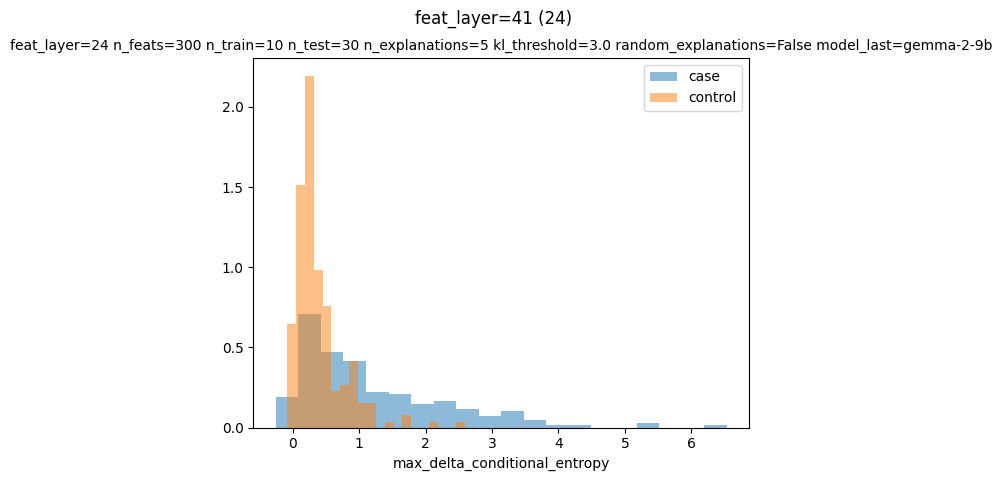

In [31]:
import matplotlib.pyplot as plt

cfg = base_cfg.copy()
case_cfg = base_cfg.copy()
case_cfg["feat_layer"] = 41

case_df = load_result(case_cfg)
cfg_df = load_result(cfg)

case_scores = case_df["max_delta_conditional_entropy"].values
cfg_scores = cfg_df["max_delta_conditional_entropy"].values

diff_keys = [k for k in case_cfg.keys() if case_cfg[k] != cfg[k]]


suptitle = " ".join([f"{k}={case_cfg[k]} ({cfg[k]})" for k in diff_keys])
title = " ".join([f"{k}={v}" for k, v in cfg.items()])
plt.hist(case_scores, bins=20, alpha=0.5, label="case", density=True)
plt.hist(cfg_scores, bins=20, alpha=0.5, label="control", density=True)
plt.suptitle(suptitle)
plt.title(title, fontsize=10)
plt.xlabel("max_delta_conditional_entropy")
plt.legend()
plt.show()



In [13]:
case_cfg

{'feat_layer': 24,
 'n_feats': 300,
 'n_train': 10,
 'n_test': 30,
 'n_explanations': 5,
 'kl_threshold': 1.0,
 'random_explanations': False,
 'model_last': 'gemma-2-9b'}